In [399]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import glob
%matplotlib inline

In [411]:
files = glob.glob('ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/*.csv')

In [410]:
files[0].split('/',1)[-1].split('.csv')[0]

'A2Benchmark/synthetic_85'

# Define parameters

In [404]:
#parameters
# file_name = 'ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS12.csv'
threshold = 4
train_prop = 0.4

# Define function to compute ARIMA model and plot

In [413]:
def plot_sarimax(file_name, threshold):
    try:
        file = pd.read_csv(file_name)
        data = file['value']
        train_data = data.iloc[:int(train_prop*len(data))]
        aic_full = pd.DataFrame(np.zeros((5,5), dtype=float))
        warnings.simplefilter('ignore')

        # Iterate over all ARMA(p,q) models with p,q in [0,6]
        for p in range(5):
            for q in range(5):
                if p == 0 and q == 0:
                    continue

                mod = sm.tsa.statespace.SARIMAX(train_data, order=(p,0,q), enforce_invertibility=False)
                try:
                    res = mod.fit(disp=False)
                    aic_full.iloc[p,q] = res.aic
                except:
                    aic_full.iloc[p,q] = np.nan

        aic_full.replace(0,10**10, inplace=True)
        aic_full.replace(np.nan,10**10, inplace=True)
        arg_min = np.argmin(aic_full)
        p,q = arg_min//5, arg_min%5

        model = sm.tsa.statespace.SARIMAX(train_data, order=(p,0,q)).fit()
        # res = mod.fit(disp=False)
        ar_params = model.params.loc[model.params.index.str.contains('ar')]
        ma_params = model.params.loc[model.params.index.str.contains('ma.L')]
        rem_data = data.iloc[int(train_prop*len(data)):]

        # Setup forecasts
        nforecasts = 1
        forecasts = {}


        # Save initial forecast
        # forecasts[rem_data.index[0]] = model.forecast(steps=nforecasts)

        residuals = model.resid
        # Step through the rest of the sample
        for t in range(rem_data.index[0], rem_data.index[-1]):
            ma_terms = residuals.iloc[t-q:t]
            ar_terms = data.iloc[t-p:t]
            forecasts[t] = ar_terms.values@ar_params.values[::-1] + ma_terms.values@ma_params.values[::-1]
            residuals.loc[t] = rem_data.loc[t] - forecasts[t]

        predicted = pd.Series(forecasts, name='value')
        file.rename(columns={'anomaly':'is_anomaly'}, inplace=True)

        # plot
        fig,ax = plt.subplots(1,1,figsize=(15,7))
        predicted.plot(ax=ax,label = 'predicted', color='red')
        # model.forecast(852).plot(ax=ax, label='forecast', color='orange')
        data.plot(ax=ax, label = 'real')
        temp_data = file.loc[rem_data.index]
        difference = predicted-rem_data
        outliers = difference.loc[difference.abs()>threshold*difference.std()]
        true_positives_index = [x for x in outliers.index if x in file.loc[file['is_anomaly']==1].index]
        false_positives_index = [x for x in outliers.index if x not in true_positives_index]
        false_negative_index = [x for x in temp_data.loc[temp_data['is_anomaly']==1].index if x not in outliers.index]
        rem_data.loc[true_positives_index].reset_index().plot('index', 'value', kind='scatter'\
                                                    ,ax=ax,label='true positives-' + str(len(true_positives_index)),color='green', marker='o',s=40)
        rem_data.loc[false_positives_index].reset_index().plot('index', 'value', kind='scatter'\
                                                    ,ax=ax,label='false positives-' + str(len(false_positives_index)),color='red', marker='o',s=40)
        rem_data.loc[false_negative_index].reset_index().plot('index', 'value', kind='scatter'\
                                                    ,ax=ax,label='false negative- ' + str(len(false_negative_index)),color='orange', marker='o',s=40)

        ax.legend(loc='upper left')
        ax.set_title('SARIMAX - ' + file_name.split('/',1)[-1].split('.csv')[0])
        plt.show()
    except:
        pass

# Sample outputs for different thresholds

0.5


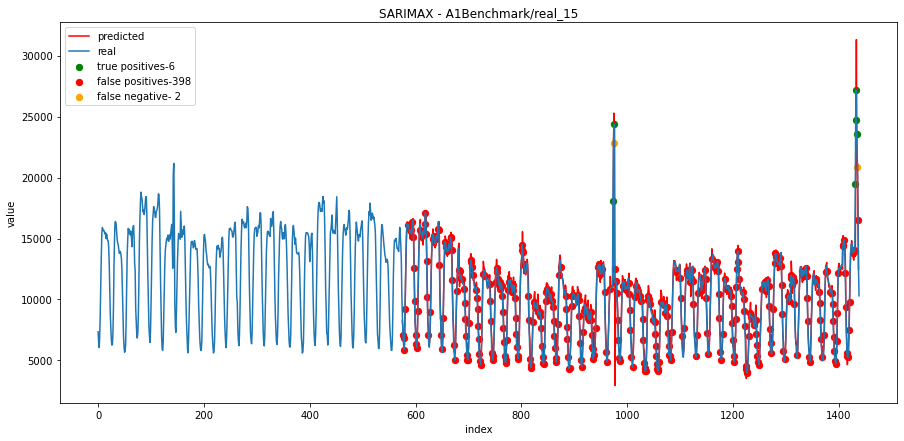

1.0


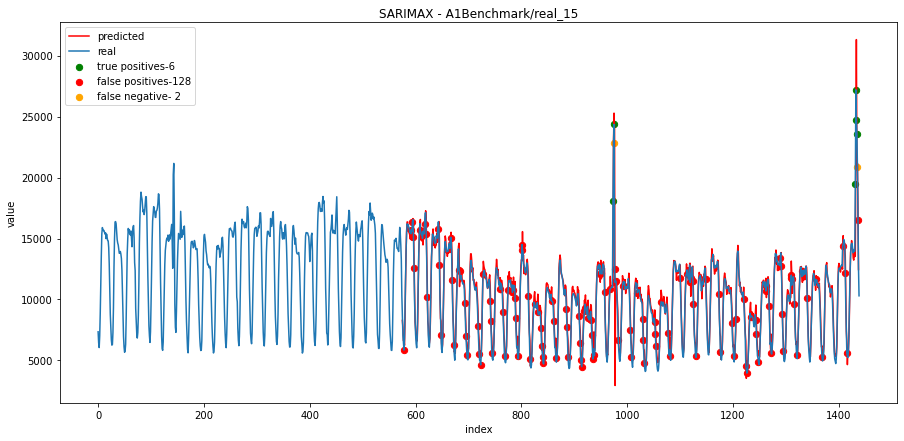

1.5


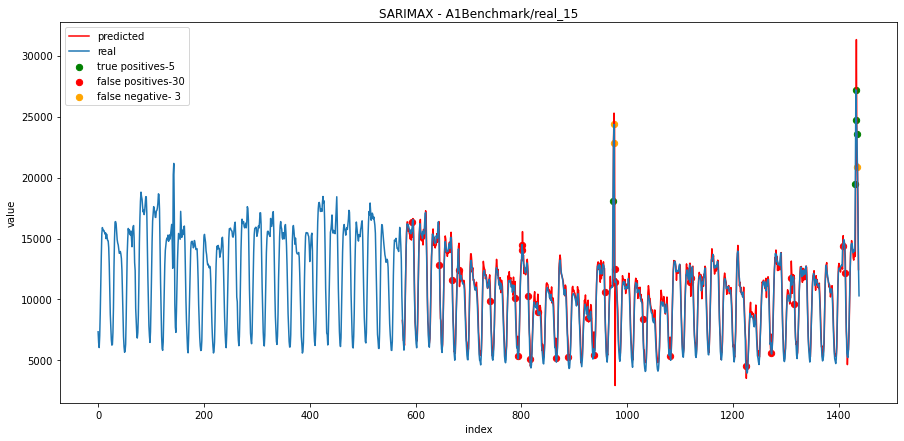

2.0


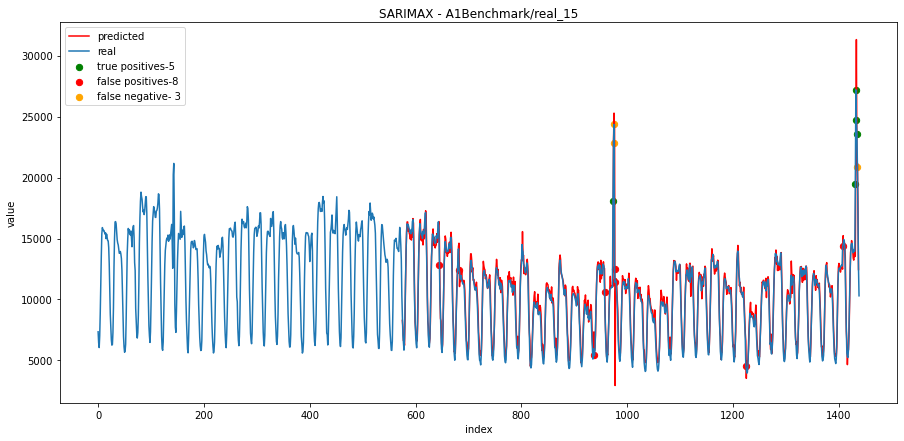

2.5


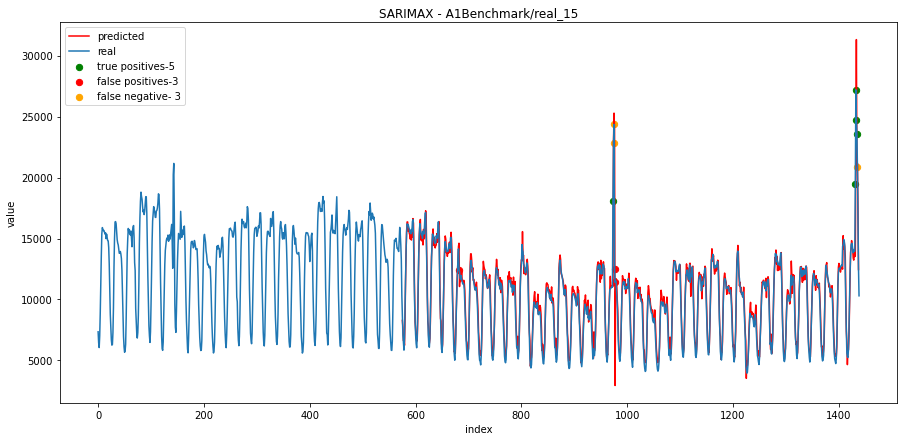

3.0


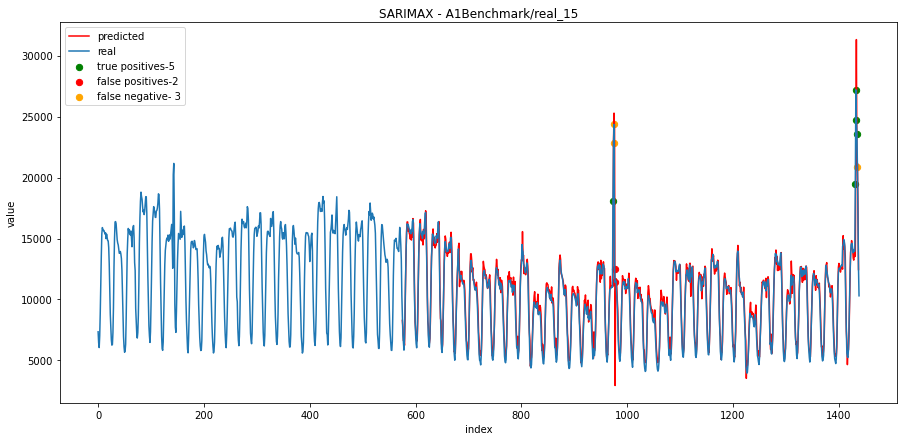

3.5


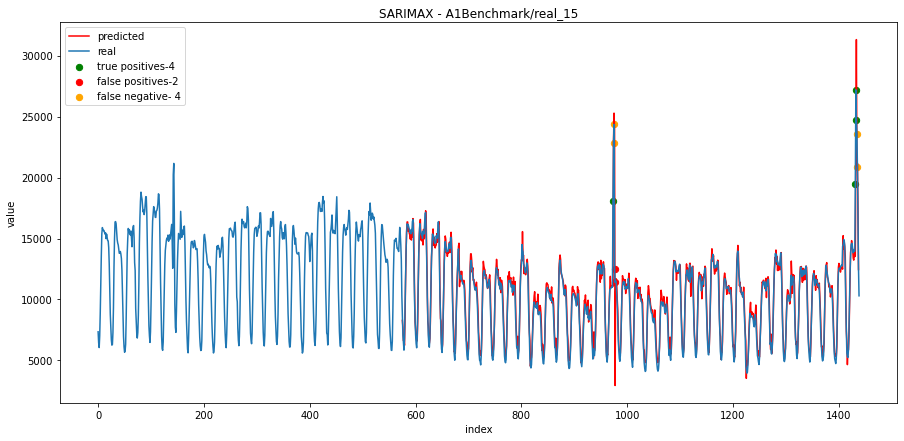

4.0


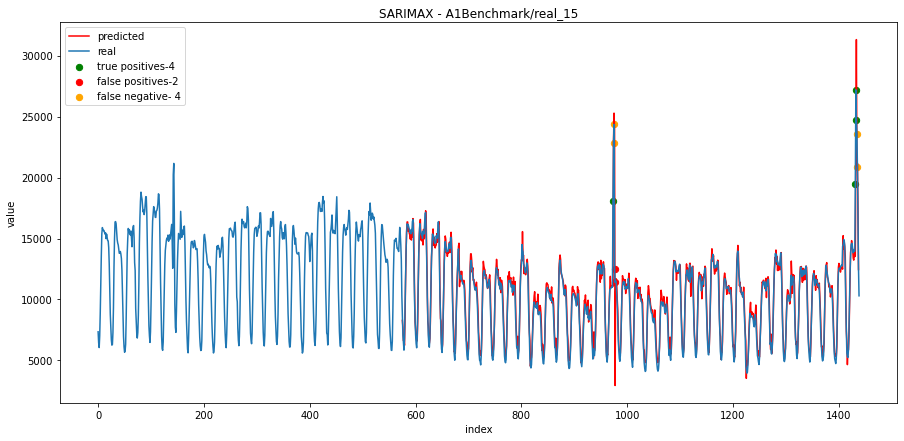

4.5


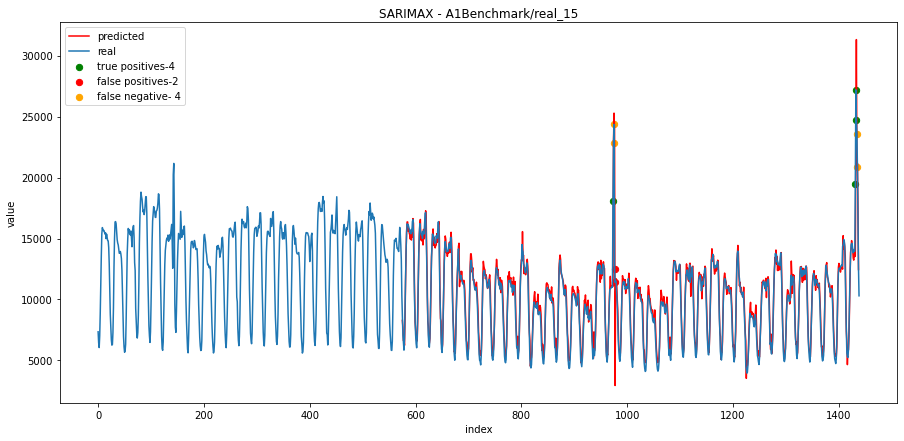

In [416]:
file_name = 'ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_15.csv'
for threshold in np.arange(0.5,5,0.5):
    print(threshold)
    plot_sarimax(file_name, threshold)

# Run for multiple files and one threshold

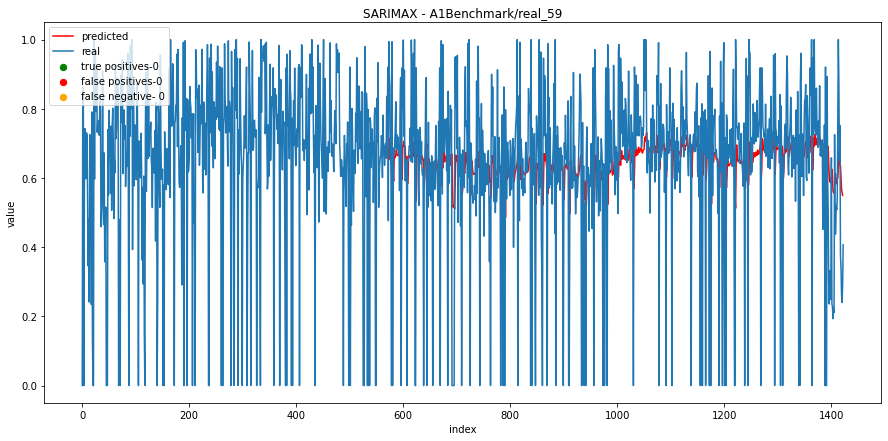

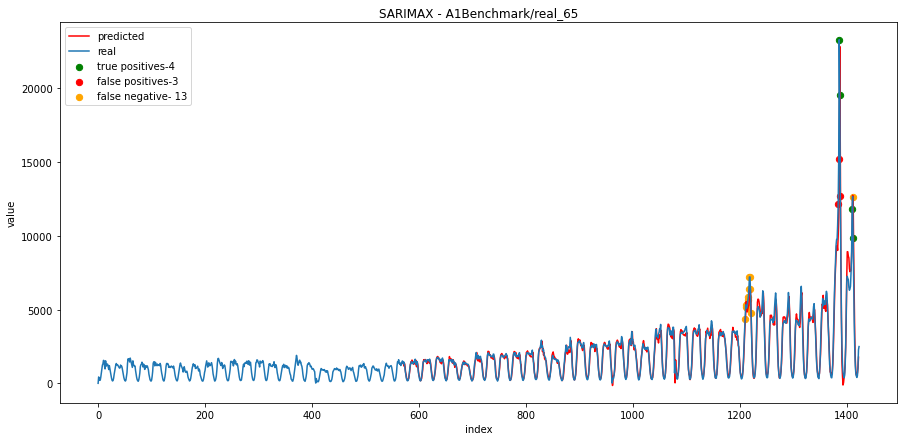

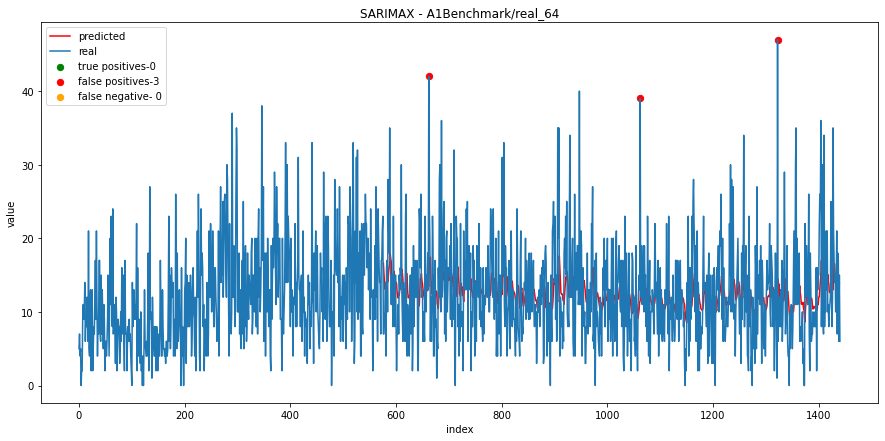

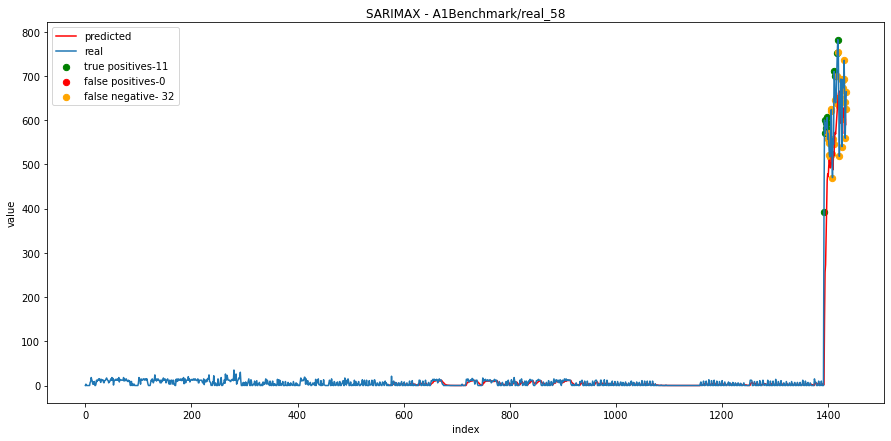

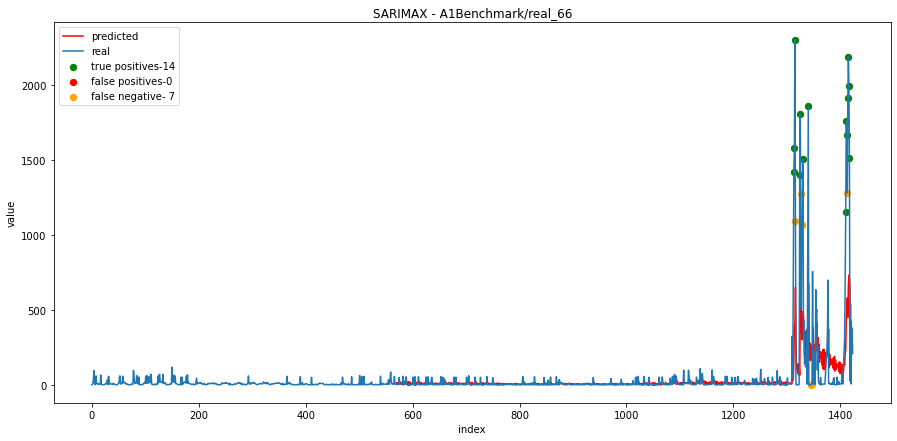

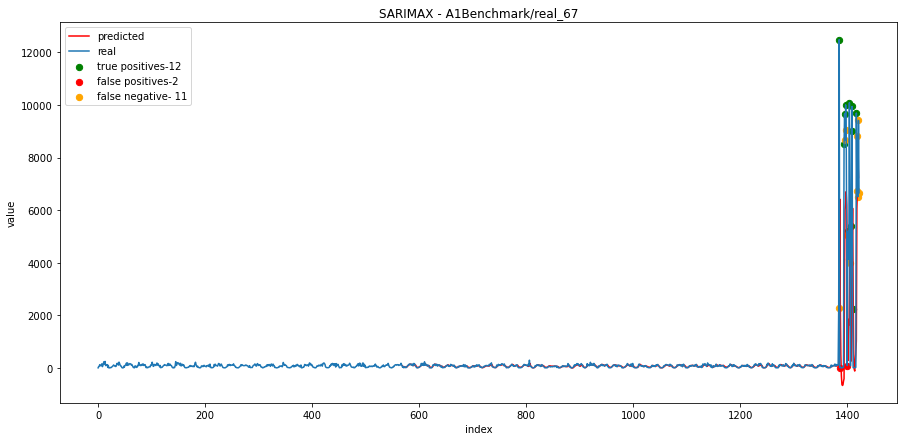

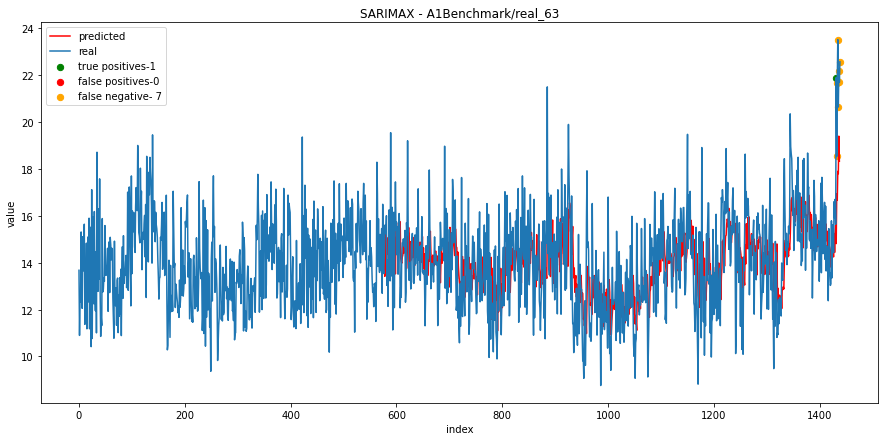

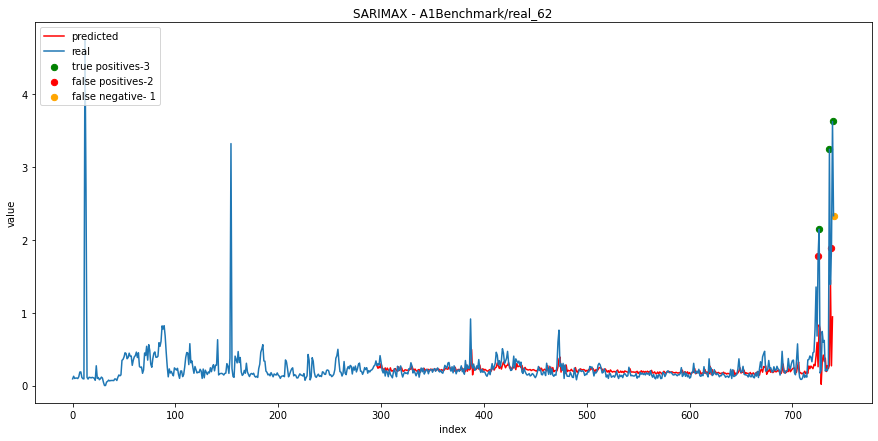

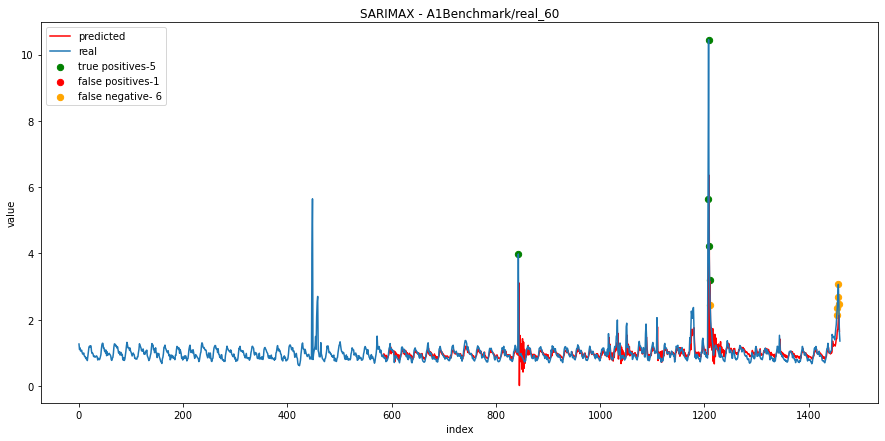

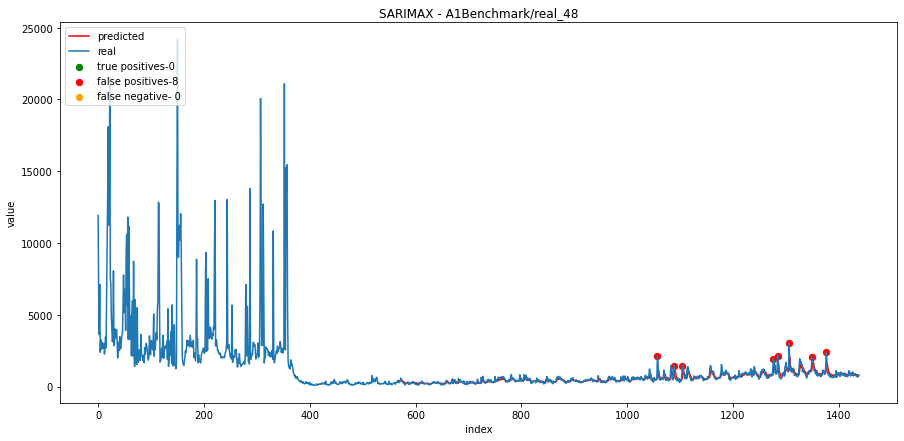

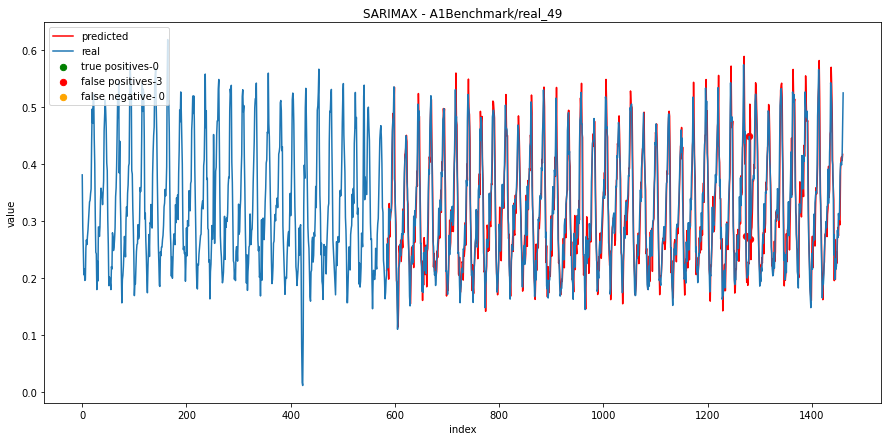

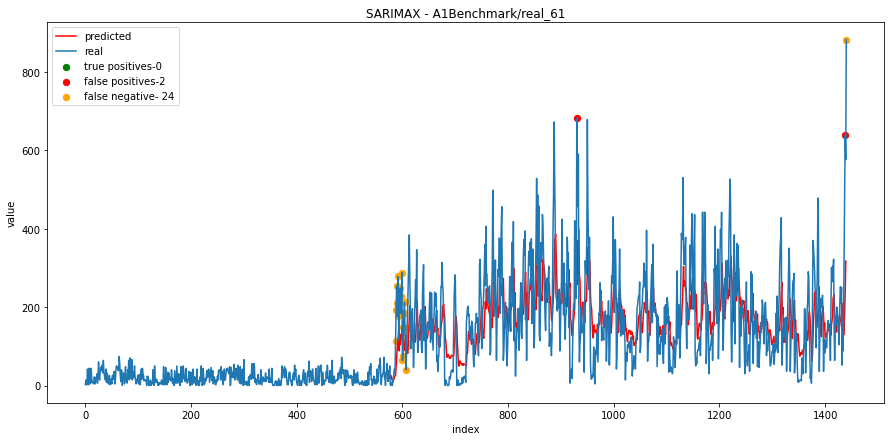

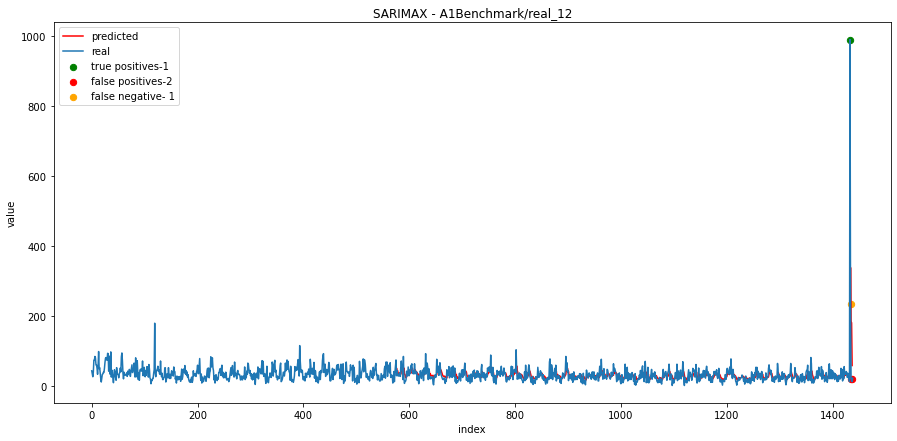

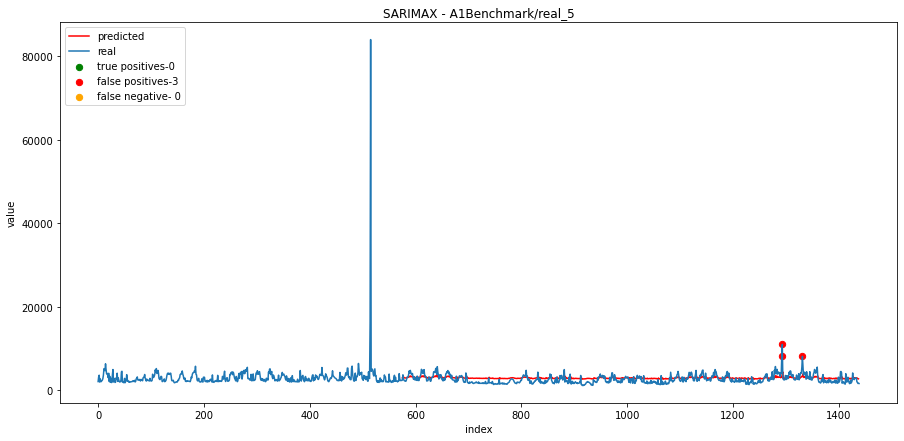

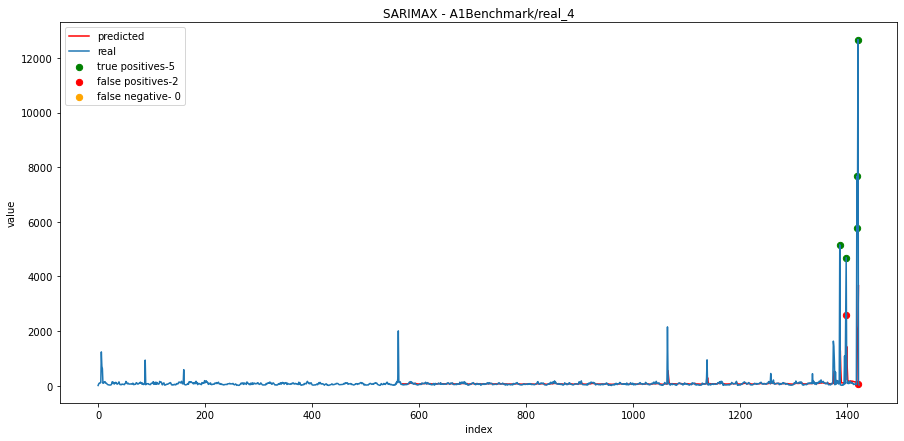

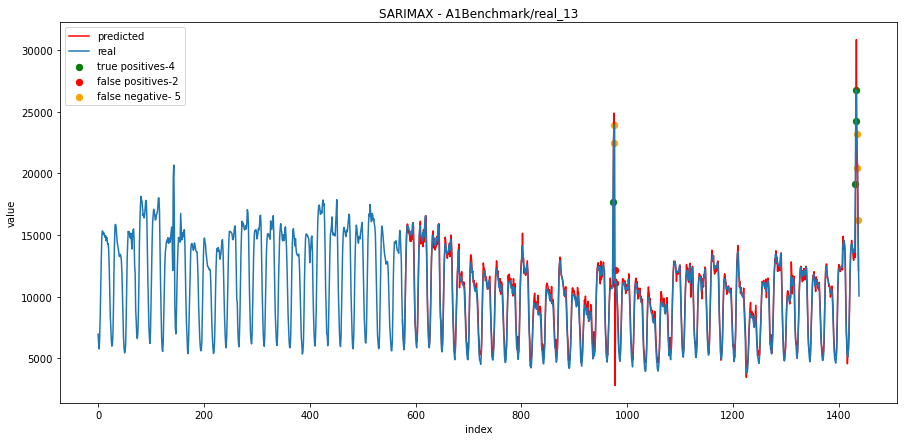

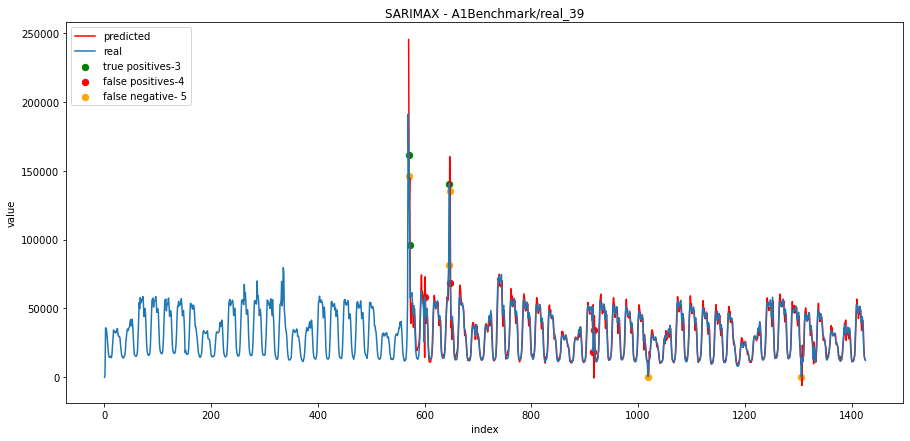

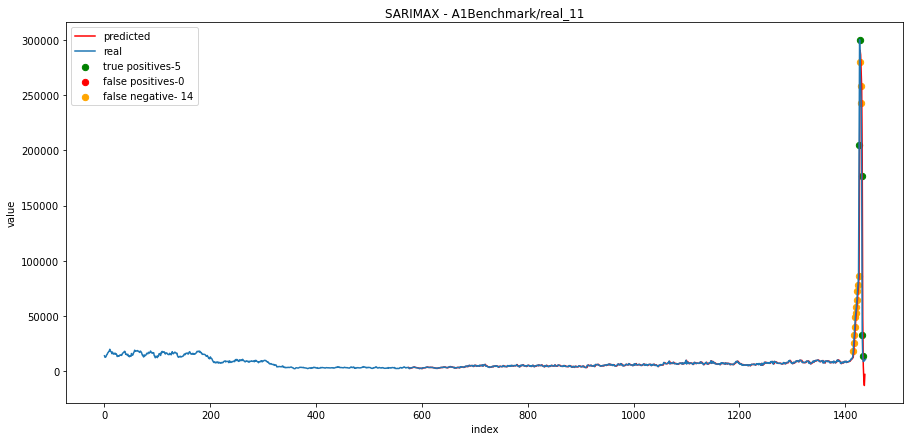

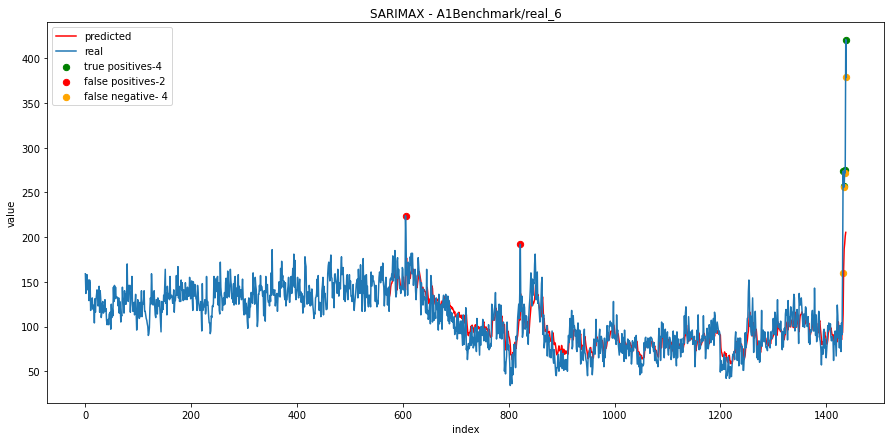

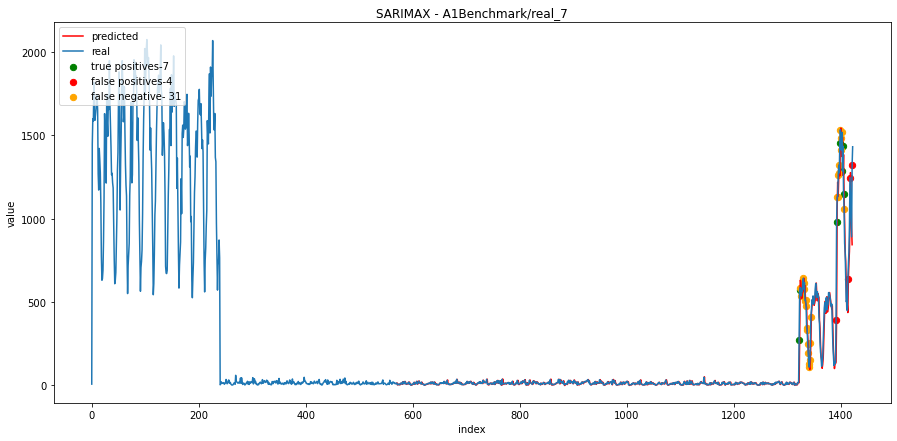

In [414]:
for file_name in files[:20]:
    plot_sarimax(file_name, threshold)

# Run for A2 Benchmark

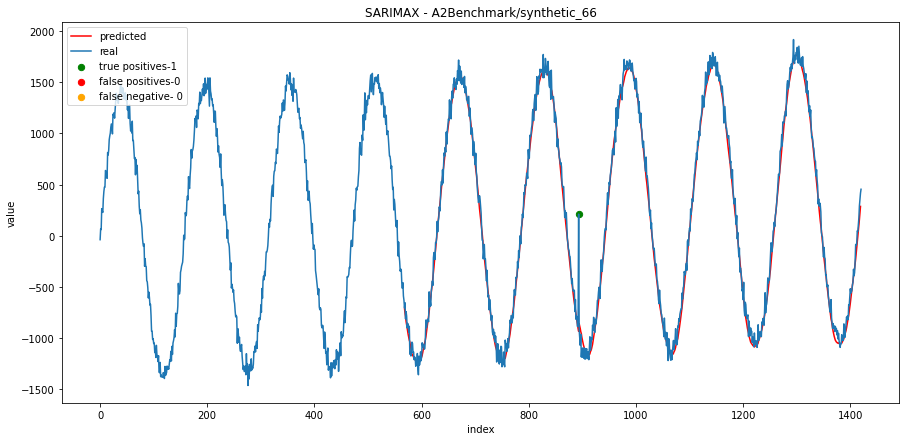

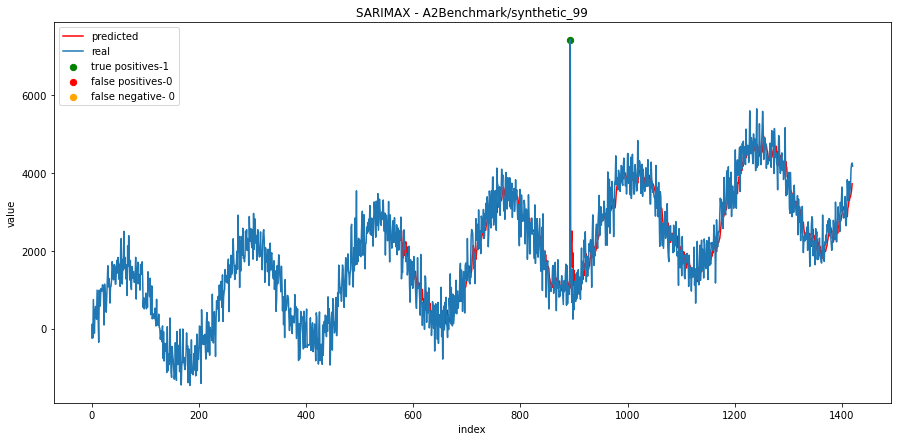

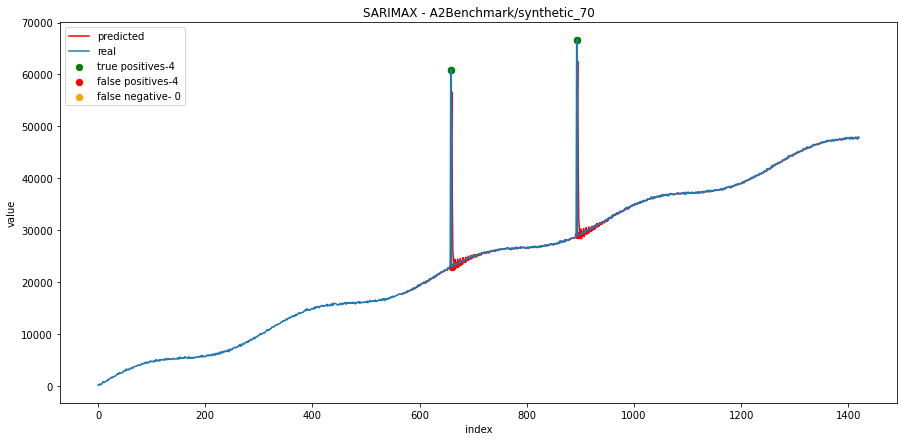

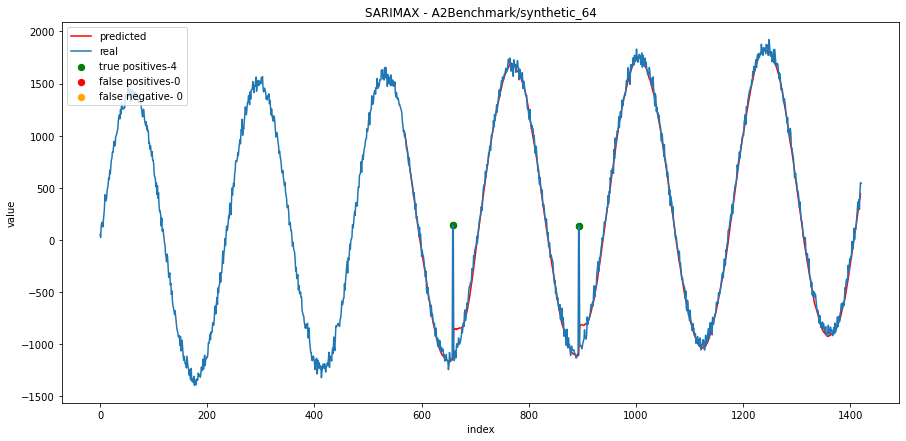

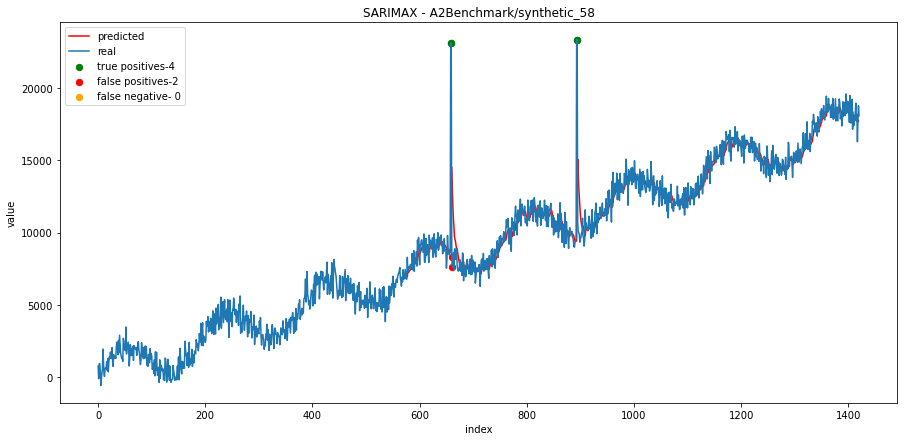

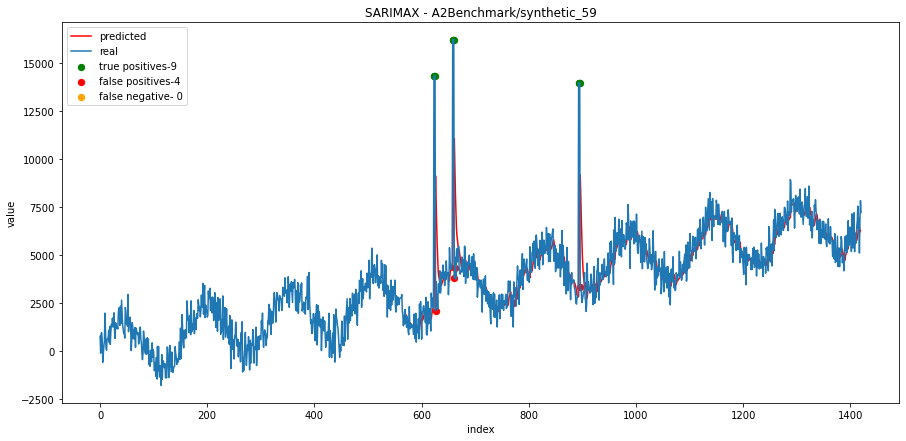

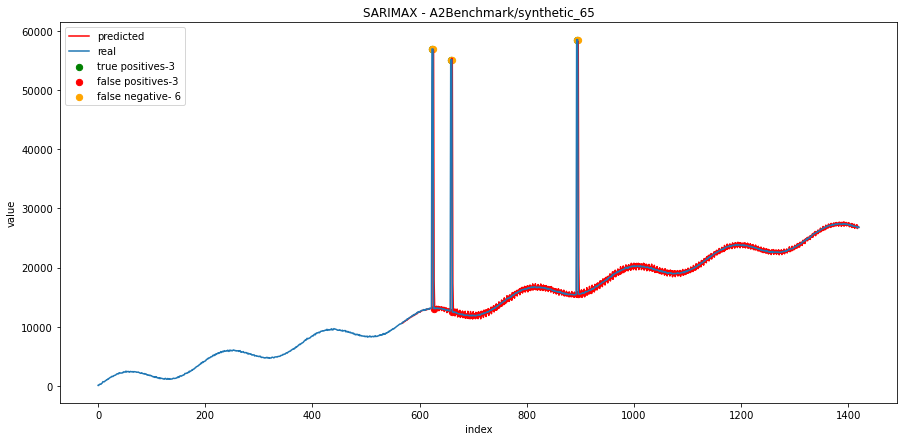

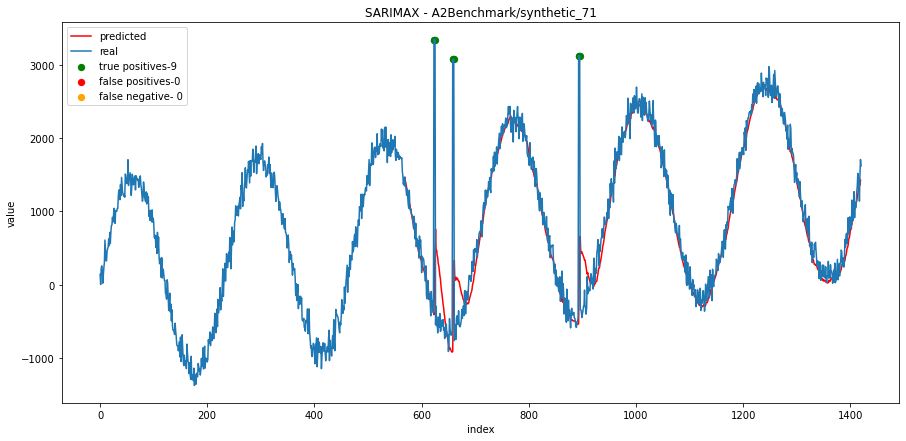

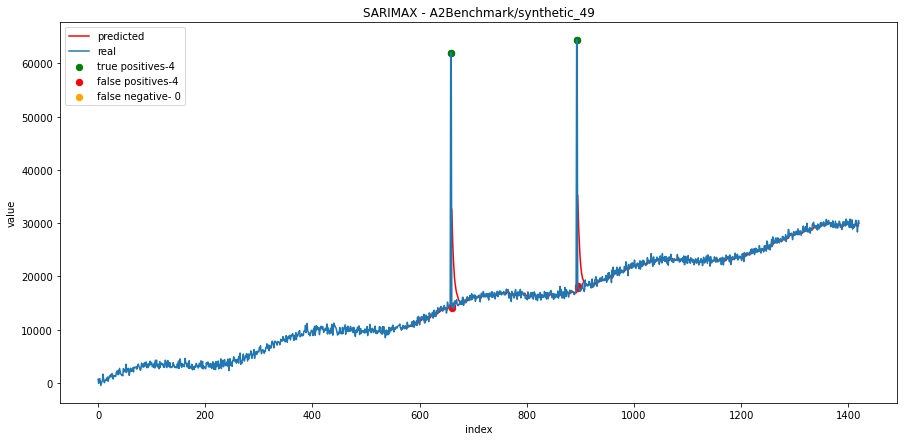

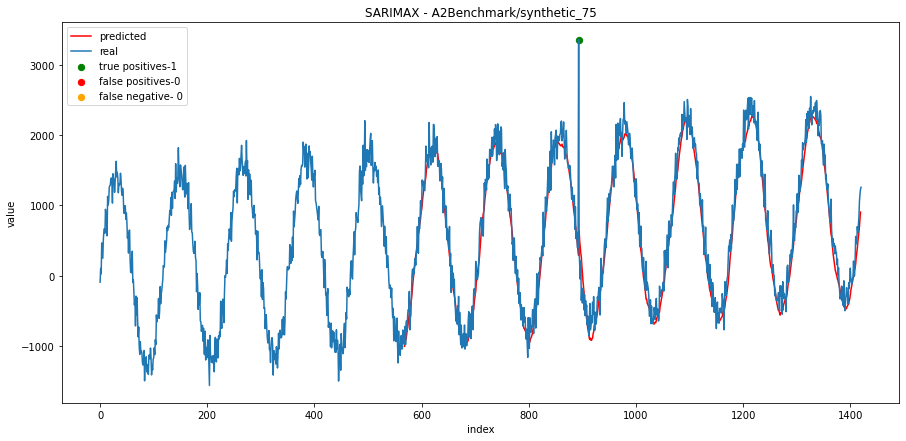

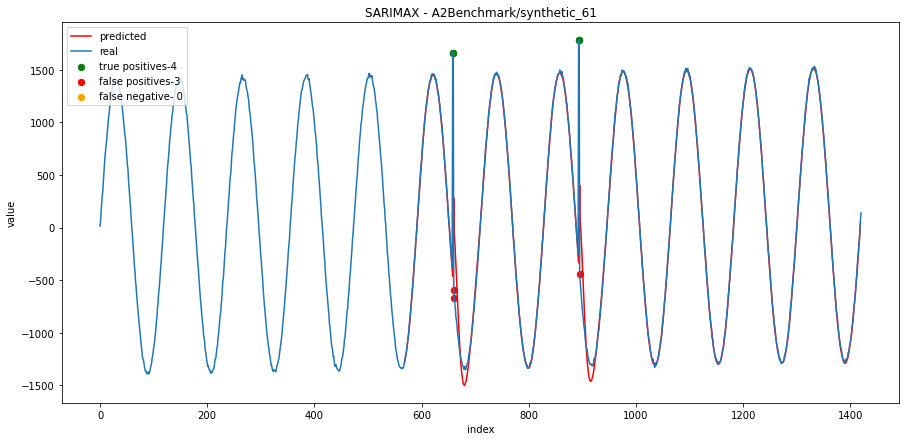

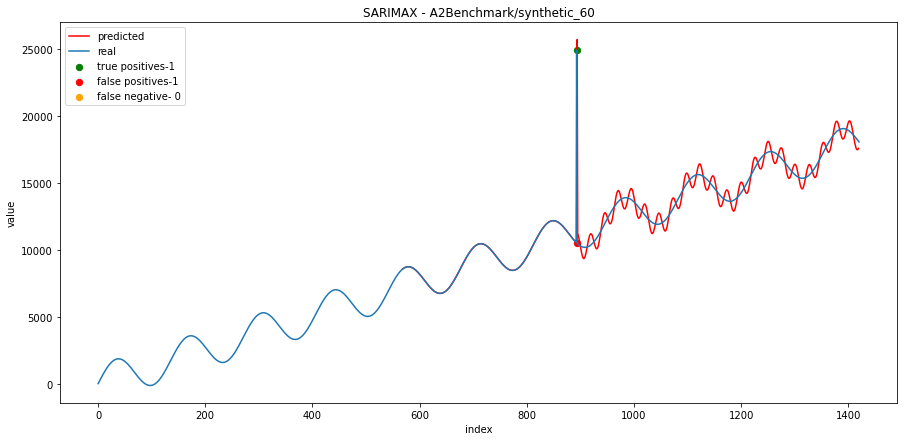

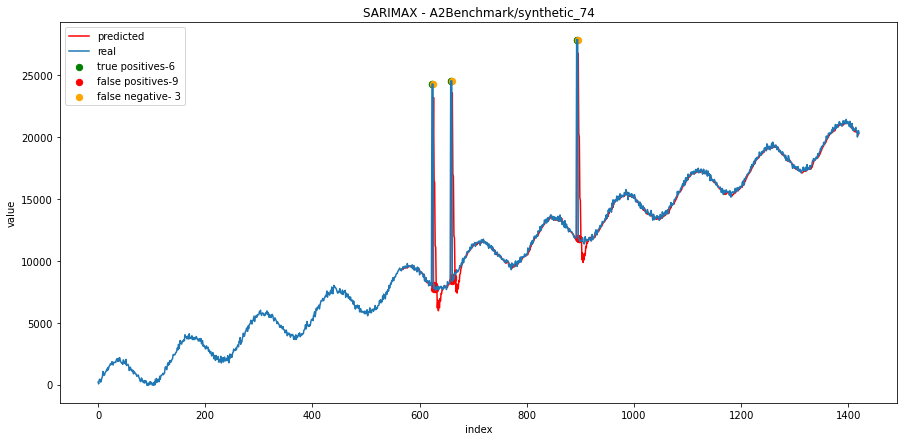

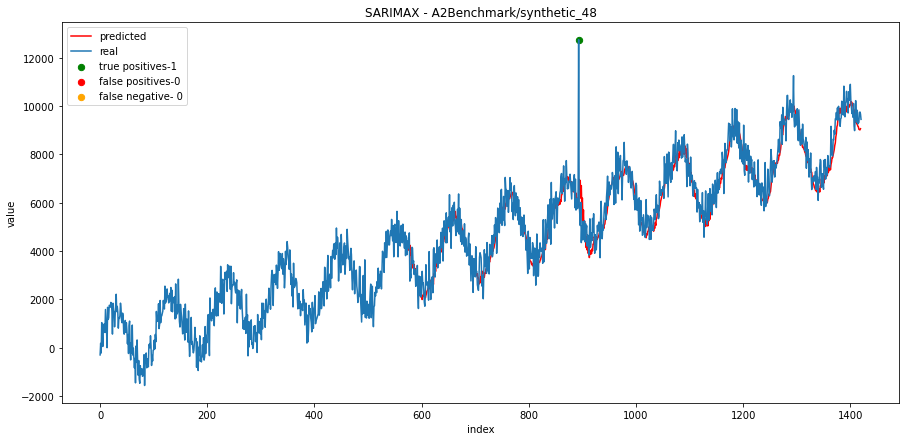

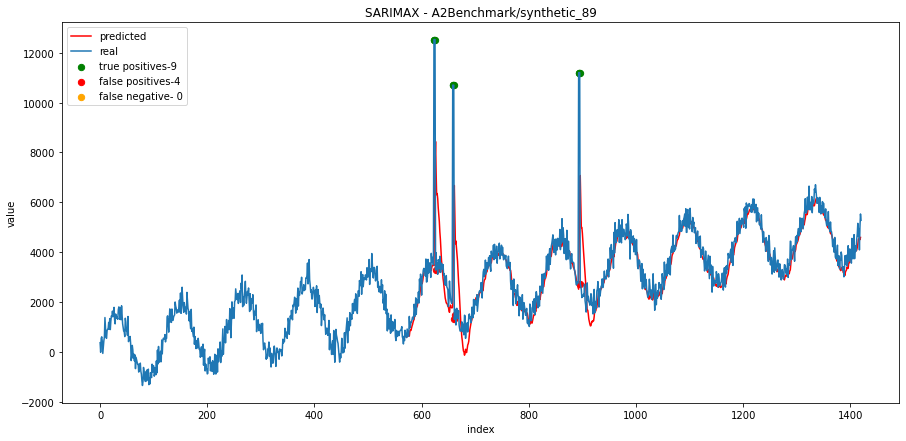

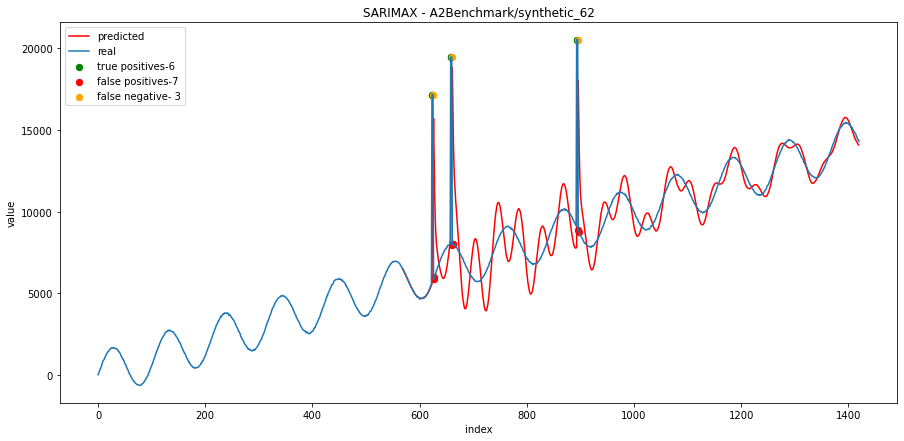

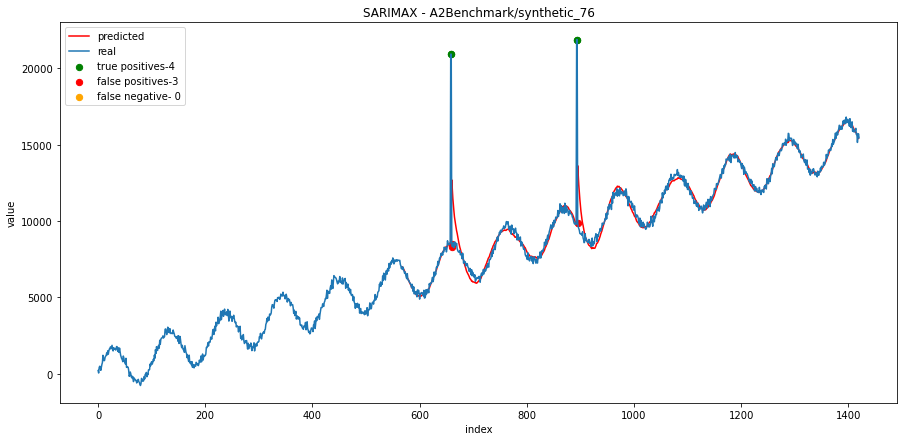

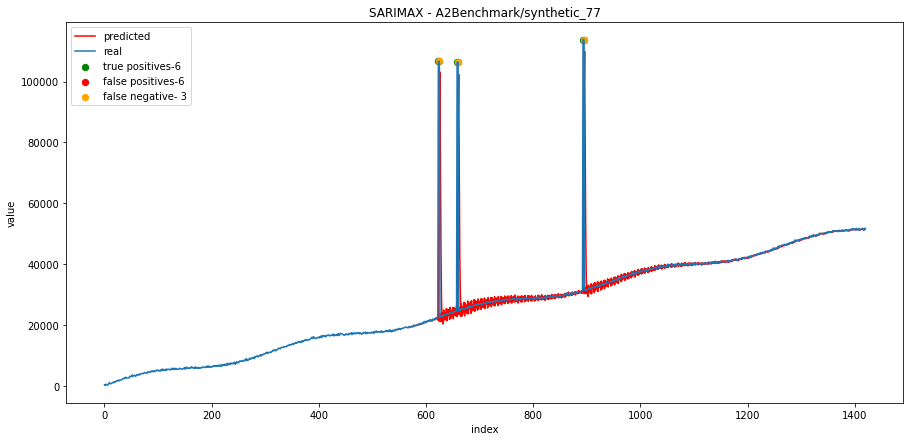

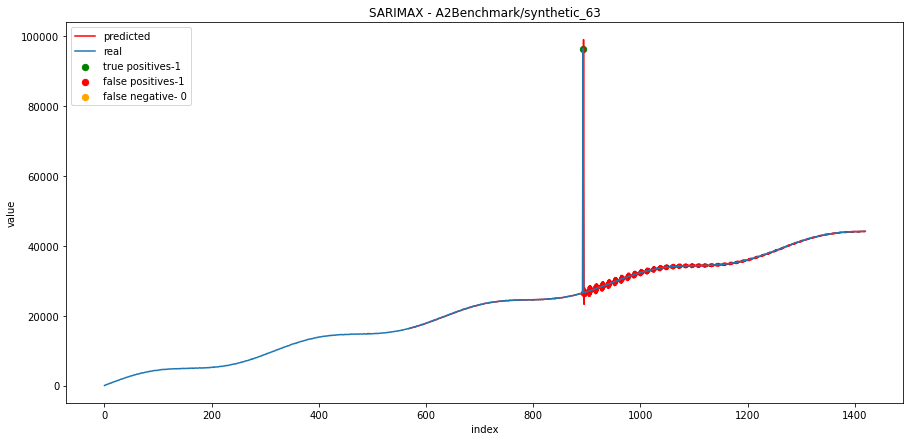

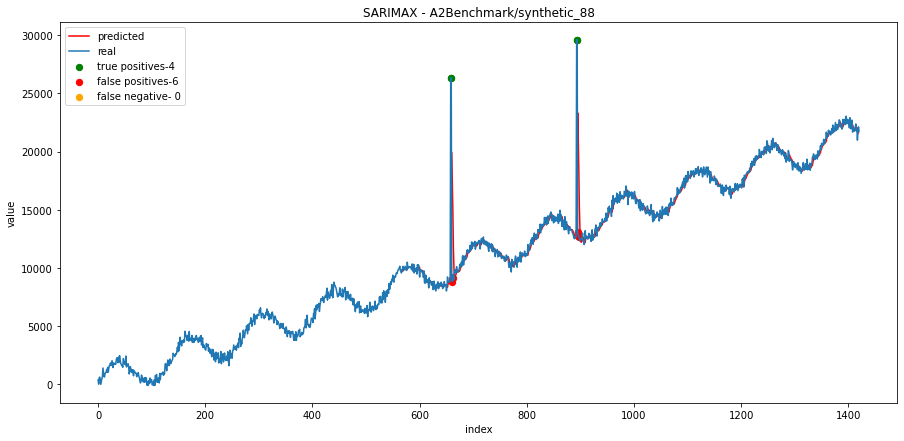

In [415]:
files = glob.glob('ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/*.csv')
for file_name in files[-20:]:
    plot_sarimax(file_name, threshold)